In [92]:
# notebook for gabor filter exercises

# import
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import os
from scipy import misc
import imageio
from scipy import signal
np.random.seed(420)
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['font.size'] = 22

# Problem 1

A V1 cell has a response kernel

\begin{equation}
f_{\alpha,a,\psi} = r_{max}\exp\left(-\frac{x^2}{2\sigma^2_x}-\frac{y^2}{2\sigma^2_y}\right)\text{cos}(a\text{cos}(\psi)x + a \text{sin}(\psi)y-\alpha)
\end{equation}

where $\alpha$ is the preferred phase, $\psi$ is the preferred orientation, and $a$ is the preferred frequency. We stimulate it with the following (static) stimulus:

\begin{equation}
s(x,y) = B\cos\left(b\cos(\phi)x + b\sin(\phi)y - \beta\right)
\end{equation}

Plot the response
\begin{equation}
L_{\alpha,a,\psi}(x_0,y_0,\phi,\beta,b) = \int dx\, dy\, f_{\alpha,a,\psi}(x,y)s(x,y)
\end{equation}

In [93]:
# Define a function that outputs a gabor filter

def L(x, y, b, phi, a=1, psi=0, sigma_x=1, sigma_y=1, alpha=1, beta=0, B=1, rmax=1):
 left_cos = np.cos(b * np.cos(phi) * x + b * np.sin(phi) * y - alpha - beta)
 left_exp = np.exp(-0.5 * ((sigma_x**2) * (b * np.cos(phi) - a * np.cos(psi))**2 + (sigma_y**2) * (b *
np.sin(phi) - a * np.sin(psi))**2))
 right_cos = np.cos(b * np.cos(phi) * x + b * np.sin(phi) * y + alpha - beta)
 right_exp = np.exp(-0.5 * ((sigma_x**2) * (a * np.cos(psi) + b * np.cos(phi))**2 + (sigma_y**2) * (a * np.sin(psi) + b * np.sin(phi))**2))

 return B * rmax * sigma_x * sigma_y * math.pi * (left_cos * left_exp + right_cos * right_exp)

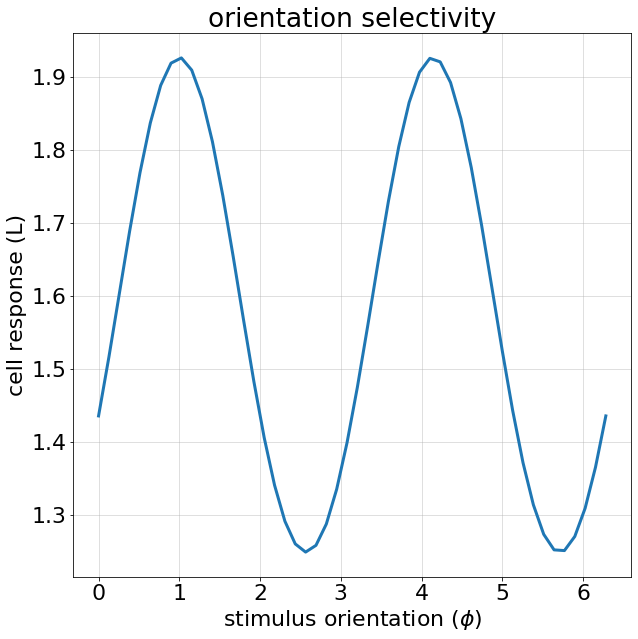

In [94]:
# Plot the orientation selectivity

orientations = np.linspace(0,2*math.pi,50)#math.pi * np.arange(-10,11) / 8
responses = [L(0, 0, 1, phi, psi=1) for phi in orientations]
plt.plot(orientations, responses, lw=3)
plt.grid(alpha=0.5)
plt.xlabel("stimulus orientation ($\phi$)")
plt.ylabel("cell response (L)")
plt.title("orientation selectivity")
plt.show()

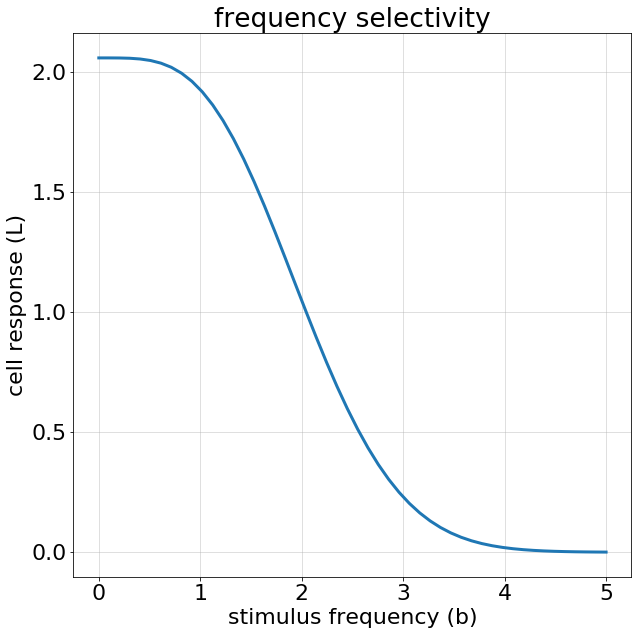

In [95]:
# plot the selectivity to stimulus frequency

frequencies = np.linspace(0, 5, num=50)
responses = [L(0, 0, b, 0) for b in frequencies]
plt.plot(frequencies, responses, lw=3)
plt.xlabel("stimulus frequency (b)")
plt.ylabel("cell response (L)")
plt.title("frequency selectivity")
plt.grid(alpha=0.5)
plt.show()

# Problem 2

Images seen through visual receptive fields

## 1) Lets look at the image

image shape:  (267, 200)


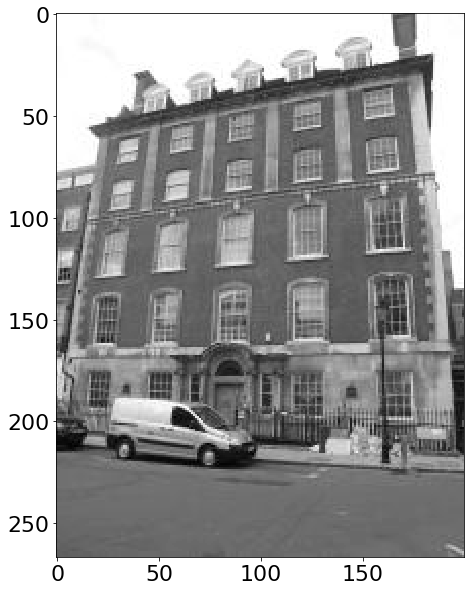

In [96]:
# load the image

image = imageio.imread('asst03_gatsby_image.bmp')
print ("image shape: ", image.shape)
plt.imshow(image)
plt.show()

## 2) Construct an on-center difference-of-gaussians (DOG) centre-surround receptive field centred at 0:
  \begin{equation}
  D(x,y) = \frac{1}{2\pi\sigma_c^2} e^{-(x^2 + y^2)/2\sigma_c^2}
  - \frac{1}{2\pi\sigma_s^2} e^{-(x^2 + y^2)/2\sigma_s^2}
  \end{equation}

In [97]:
# define a gaussian function and use it to define a Difference-of-Gaussians

def gauss2d(x, y, sigma):
    # 2D gaussian centered at 0
    return (1.0 / (2 * math.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

def DoG(x, y, sigma_center=1.5, sigma_surround=3.0):
    # Difference of Gaussians (use gauss2D)
    return gauss2d(x, y, sigma_center) - gauss2d(x, y, sigma_surround)

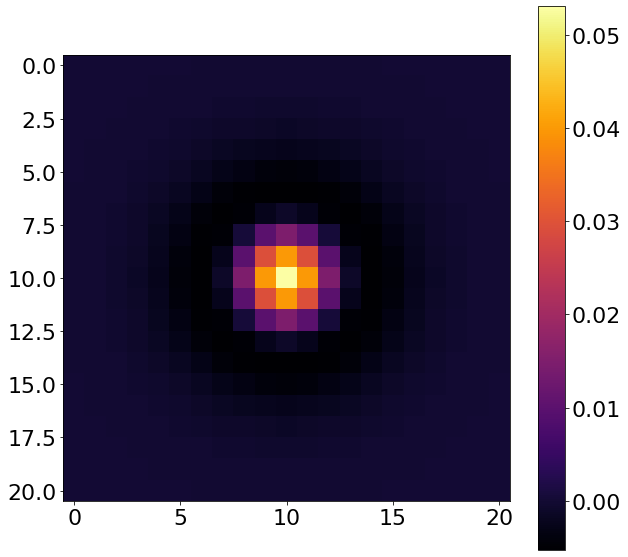

In [98]:
# plot the Difference-of-Gaussians

n = 21
RF = np.zeros((n, n))
for x in range(-10, 11):
    for y in range(-10, 11):
        RF[x+10, y+10] = DoG(x, y)
plt.imshow(RF, interpolation='none', cmap="inferno")
plt.colorbar()
plt.show()

## 3) Suppose you had a cell with a receptive field like this centered at each pixel in the image.  Show the image as represented by the activity of these cells, placing the cells in topographic order according to their centres.  (Hint: this is effectively a 2D convolution.  Why?).

In [106]:
def Convolve(image, recep_field):
    # convolve image with receptive field
    return signal.convolve(image, recep_field, mode='same')

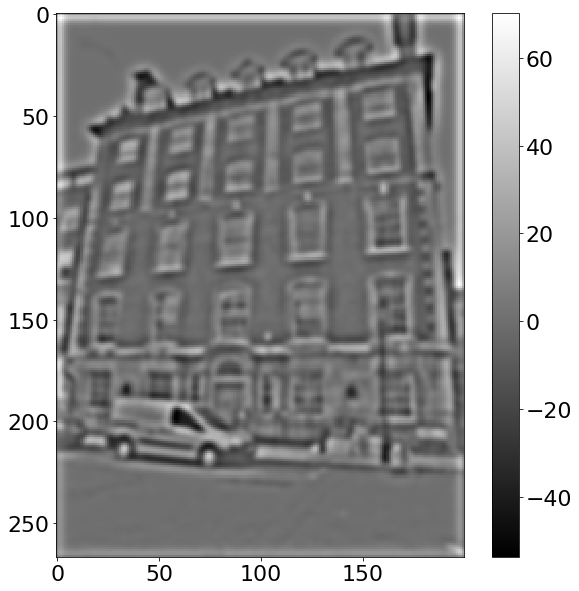

In [114]:
DoG_img = Convolve(image, RF)
plt.imshow(DoG_img, interpolation='none')
plt.colorbar()
plt.show()

## 4) Threshold the activity image (i.e. set all the values above some cutoff to 1, all below to 0).  Does this look like the cells are detecting edges?  Tune the parameters of the DOG RF and the threshold to improve the quality of the edge detection as much as you can.

In [108]:
# define threshold function

def threshold(image, val):
    return (image > val).astype(float)

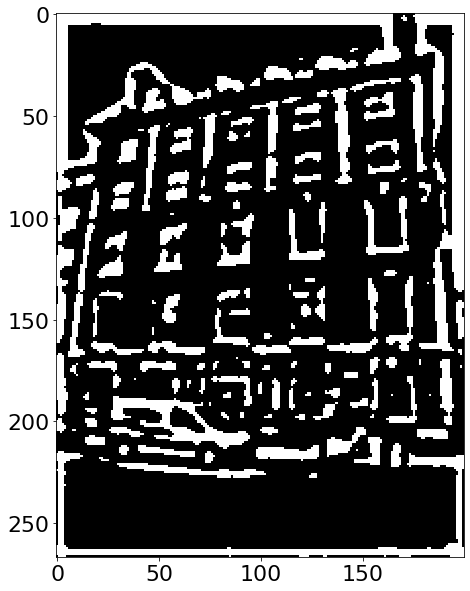

In [115]:
# threshold the image and plot

thresholded_image = threshold(DoG_img, val=8)
plt.imshow(thresholded_image, interpolation='none')
plt.show()

## 4) Now construct a Gabor receptive field on the same 21-by-21 pixel grid: 

  \begin{equation}
  D(\vec{x}) = \exp\Big(-\frac{(\vec{k}(\theta) \cdot \vec{x})^2}{2\sigma_l^2} 
  -\frac{(\vec{k}_{\perp}(\theta) \cdot \vec{x})^2}{2\sigma_w^2}\Big)
  \cos\Big(2\pi \frac{\vec{k}_{\perp}(\theta) \cdot \vec{x}}{\lambda}
  + \phi\Big)
  \end{equation}
  
  where $\vec{k}(\theta)$ is a unit vector with the orientation $\theta$, $\vec{k}_{\perp}(\theta)$ is an orthogonal unit vector and $\theta$, $\sigma_l$, $\sigma_w$, $\lambda$ and $\phi$ parametrise the Gabor.  Start with $\theta = \pi/2$, $\sigma_l = \sigma_w = 3$ pixels, $\lambda = 6$ pixels and $\phi = 0$.

In [116]:
# define the gabor filter


def gabor(x, theta=math.pi/2.0, sigma_l=3, sigma_w=3, lmbda=6, phi=0):
    assert type(x) == np.ndarray and len(x) == 2, "invalid x: must be a 2D vector"

    # find x, y coords for given angle
    kx = np.cos(theta)
    ky = np.sin(theta)
    k = np.array([kx, ky])
    # define orthogonal vector
    k_perp = np.array([-ky, kx])
    # normalize
    k = k / np.linalg.norm(k)
    k_perp = k_perp / np.linalg.norm(k_perp)
    # exponential term
    left = np.exp(-(np.sum(k * x)**2)/(2 * sigma_l**2) - (np.sum(k_perp * x)**2)/(2
    * sigma_w**2))

    # cosine term
    right = np.cos(2 * math.pi * np.sum(k_perp * x) / lmbda + phi)

    return left * right

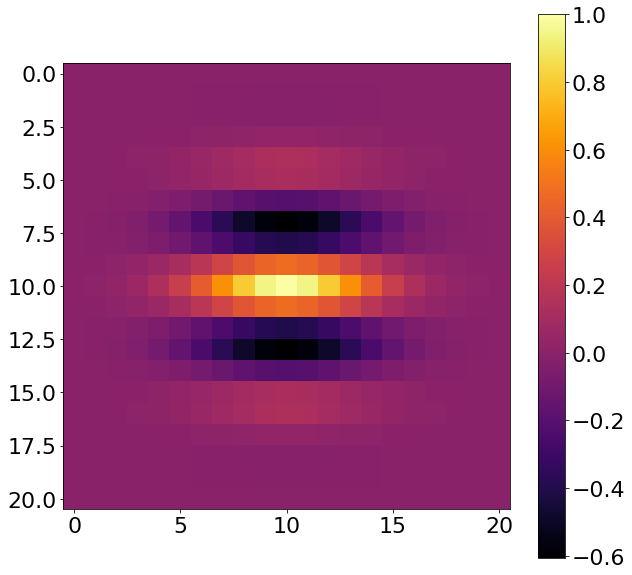

In [117]:
# plot the gabor receptive field

n = 21
gabor_RF = np.zeros((n, n))
for x in range(-10, 11):
    for y in range(-10, 11):
        gabor_RF[x+10, y+10] = gabor(np.array([x, y]))
plt.imshow(gabor_RF, interpolation='none', cmap="inferno")
plt.colorbar()
plt.show()

## 5) Show the image as seen by through receptive fields of this sort, again with one centred at each pixel in the image.  Threshold the activities.

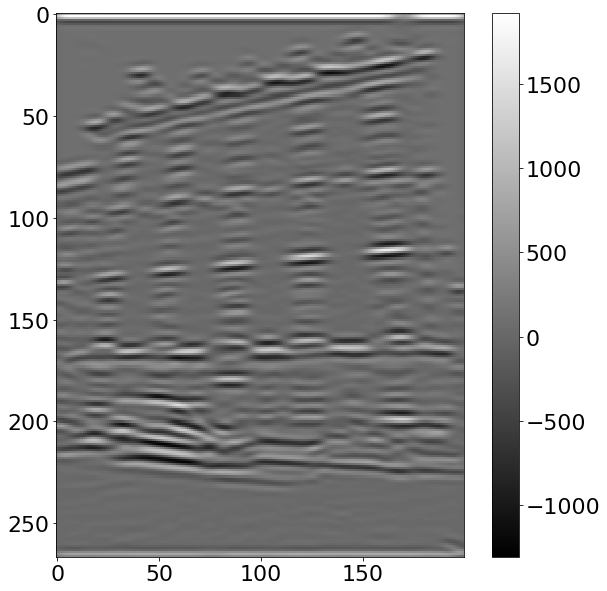

In [112]:
gabor_response = Convolve(image, gabor_RF)
plt.imshow(gabor_response, interpolation='none')
plt.colorbar()
plt.show()

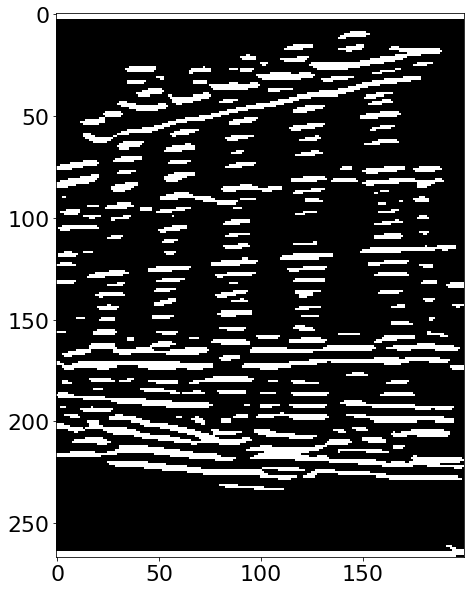

In [118]:
thres_gabor = threshold(r_gabor, 200.0)
plt.imshow(thres_gabor, interpolation='none')
plt.show()

## 6) Construct 3 Gabors with $\theta = 0, \pi/4, \pi/2$ and the other parameters as above.  Sum the thresholded outputs of all three types of cell.  Does this image look any better than that obtained by the RGC?  Why do you think this is?

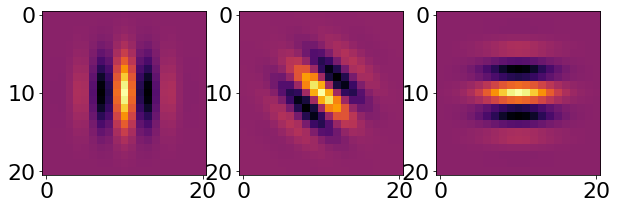

In [67]:
# plot the three gabor filters

gRFs = []
fig, axs = plt.subplots(1, 3)
for i,theta in enumerate([0, math.pi/4, math.pi/2]):
    n = 21
    gRF = np.zeros((n, n))
    for x in range(-10, 11):
        for y in range(-10, 11):
            gRF[x+10, y+10] = gabor(np.array([x, y]), theta=theta)

    gRFs.append(gRF)
    axs[i].imshow(gRF, interpolation='none', cmap="inferno")
plt.show()

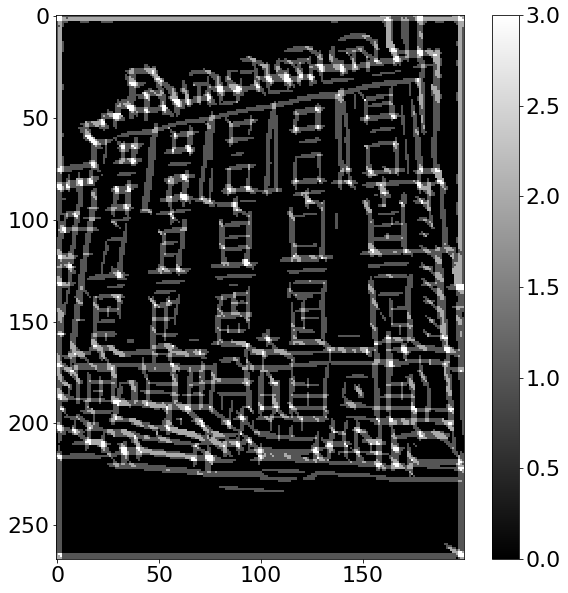

In [121]:
# get responses from 3 gabors and sum them (use gRFs - the three receptive fields)

summed_response = np.zeros_like(image, dtype=np.float64)
for i, filt in enumerate(gRFs):
    # convolve
    L = Convolve(image, filt)
    # threshold
    L_thresh = threshold(L, 200.0)
    # sum
    summed_response += L_thresh

plt.imshow(summed_response)
plt.colorbar()
plt.show()